In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.markov_switching import MarkovRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Load Brent Oil Prices Dataset
brent_data = pd.read_csv('brent_oil_prices.csv')  # Adjust the file name accordingly
brent_data['Date'] = pd.to_datetime(brent_data['Date'])
brent_data.set_index('Date', inplace=True)

# Load Economic Indicators Dataset (example)
gdp_data = pd.read_csv('gdp_data.csv')  # Load GDP data
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
gdp_data.set_index('Date', inplace=True)

# Merge datasets
data = brent_data.join(gdp_data, how='inner')  # Adjust according to your datasets
data.columns = ['Brent Price', 'GDP']  # Update column names accordingly

# Data Preprocessing
data.dropna(inplace=True)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
plt.plot(data['Brent Price'], label='Brent Oil Prices', color='blue')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Correlation Analysis
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# ADF Test for Stationarity
adf_result = adfuller(data['Brent Price'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# VAR Model
model = VAR(data)
results = model.fit(maxlags=15, ic='aic')
print(results.summary())

# Forecasting with VAR
forecast = results.forecast(data.values[-results.k_ar:], steps=10)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=10, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data.columns)
plt.figure(figsize=(12, 6))
plt.plot(data['Brent Price'], label='Historical Brent Price', color='blue')
plt.plot(forecast_df['Brent Price'], label='Forecasted Brent Price', color='orange')
plt.title('Brent Oil Prices Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# LSTM Model
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Brent Price'].values.reshape(-1, 1))

# Create a dataset with the desired time steps
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, time_step=10)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate the LSTM model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'MSE: {mse}, MAE: {mae}')

# Plot LSTM Predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + 10:], predictions, label='LSTM Predictions', color='red')
plt.plot(data['Brent Price'].values[train_size + 10:], label='Actual Prices', color='blue')
plt.title('Brent Oil Prices Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression  # Correct import
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


Merged Annual Data:
            Brent Price         GDP
Date                               
2001-12-31        19.35  10400000.0
2002-12-31        30.12  10600000.0
2003-12-31        30.30  10800000.0
2004-12-31        40.38  11000000.0
2007-12-31        93.68  11800000.0


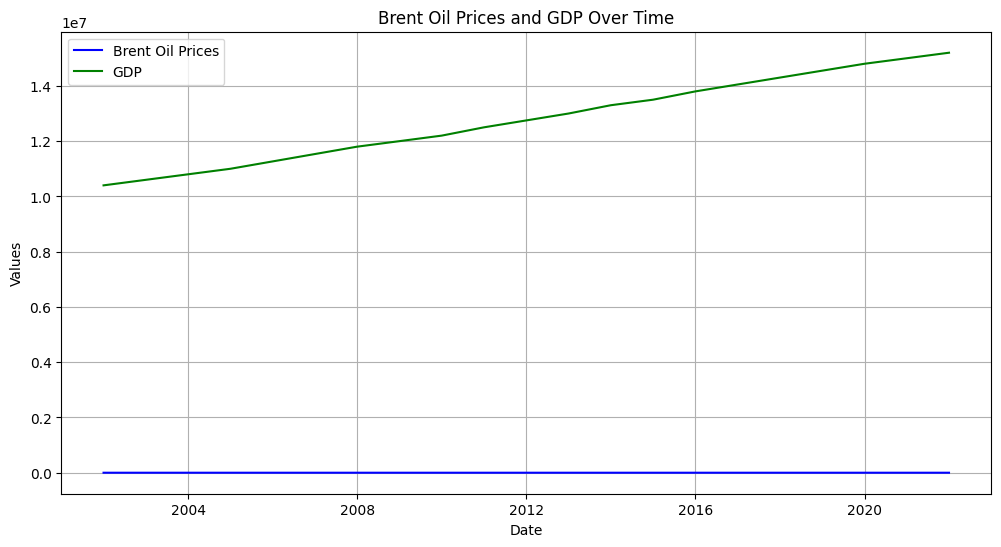

In [18]:
# Load the Brent Oil Prices Dataset
brent_data = pd.read_csv(r'/home/bamw/Downloads/Compressed/data-20241101T120533Z-001/data/Copy of BrentOilPrices.csv')
brent_data['Date'] = pd.to_datetime(brent_data['Date'])
brent_data.set_index('Date', inplace=True)

# Load the GDP Data
gdp_data = pd.read_csv(r'/home/bamw/Downloads/gdp_data.csv')  
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
gdp_data.set_index('Date', inplace=True)

# Resample GDP data to ensure it's annual (if not already)
gdp_data_annual = gdp_data.resample('A').mean()  # Resample to annual frequency

# Now merge with Brent oil prices
data_annual = brent_data.join(gdp_data_annual, how='inner')  
data_annual.columns = ['Brent Price', 'GDP']  

# Check the merged data
print("Merged Annual Data:")
print(data_annual.head())

# Plotting the data
plt.figure(figsize=(12, 6))

# Plot Brent Prices
plt.plot(data_annual.index, data_annual['Brent Price'], label='Brent Oil Prices', color='blue')
# Plot GDP
plt.plot(data_annual.index, data_annual['GDP'], label='GDP', color='green')

plt.title('Brent Oil Prices and GDP Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()


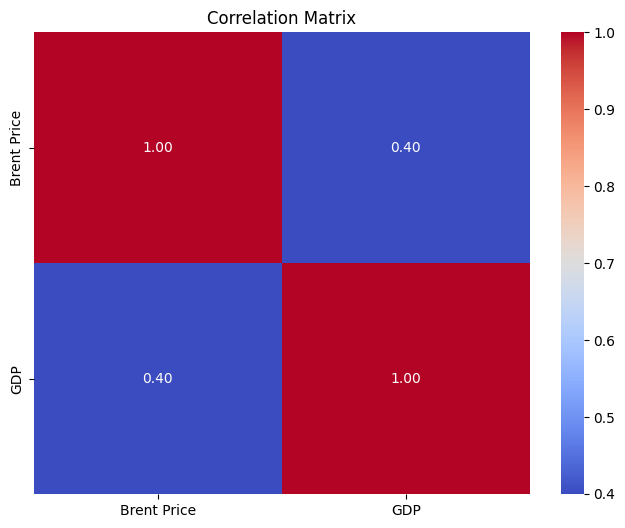

In [20]:
# Correlation Analysis
plt.figure(figsize=(8, 6))
sns.heatmap(data_annual.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
